In [1]:
import random
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import invgamma
from functools import partial
import statistics
plt.style.use('classic')

In [2]:
def rw2(n):# this gives samples from gamma(2,1)
    x,y=0,0
    distance=[]
    for i in range(1,n+1):
            r=np.random.gamma(alpha,beta) # step size r,1/beta-rate
            theta=2.*math.pi*random.random()
            x +=r*math.cos(theta)
            y +=r*math.sin(theta)
            distance.append(r)# save the distances r for the mcmc sampler
    return(np.array(distance))# depending what do you want to do, either save the pairs, or save the distances r  between points
    #return(x,y)
    
alpha=2 # shape
beta=1 #scale parameter
n=10000
data = rw2(n)# very important because you need the same data, if you put rw2(n) in there you change the data every time
#data
#the best results I got with 100000,100000,stepsize 0.1 and burn-in 1000
#inverse scale parameter beta = 1/theta, called a rate parameter.

In [3]:
# calculate the log likelihood of gamma(alpha,beta)
import scipy.stats 
from scipy.stats import gamma
import numpy as np
from numpy import prod
def log_likelihood(x,alpha,beta):# alpha is the shape, beta is the scale
     return np.sum(np.log(x**(alpha-1)*np.exp(-x/beta)/(math.gamma(alpha)*beta**alpha)))
def likelihood(x,a_scale,a_shape):
     return prod(gamma.pdf(x,scale=a_scale,a=b_shape))

In [4]:
import scipy.stats as stats
from scipy.stats import invgamma
# the shape is known and the rate or scale parameter is unknown
#Prior parameters
ap=1
bp=2
shape_fixed=2
# initial guess for theta(a and b) as array. Now the shape 2 is fixed, the prior is inverse gamma(1,2)
guess = 2# initial guess for scale
# Prepare storing MCMC chain as array of arrays.
A = [guess]
# define stepsize of MCMC.
stepsizes = 0.02 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,shape_fixed,old_theta)#calculate the first log likelihood
old_logtarget=old_loglik+gamma.logpdf((1/old_theta),ap,scale=bp)
# Metropolis-Hastings with 500,000 iterations.
for p in range(10000):
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta<0: 
        continue
    new_loglik = log_likelihood(data,shape_fixed,new_theta)
    new_logtarget=new_loglik+gamma.logpdf((1/new_theta),ap,scale=bp)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_logtarget > old_logtarget):
        A.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
        old_logtarget=new_logtarget
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_logtarget-old_logtarget)):
            A.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
            old_logtarget=new_logtarget 
        else:
            A.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))


Acceptance rate = 0.3924


Text(0.5,0,'Scale Parameter')

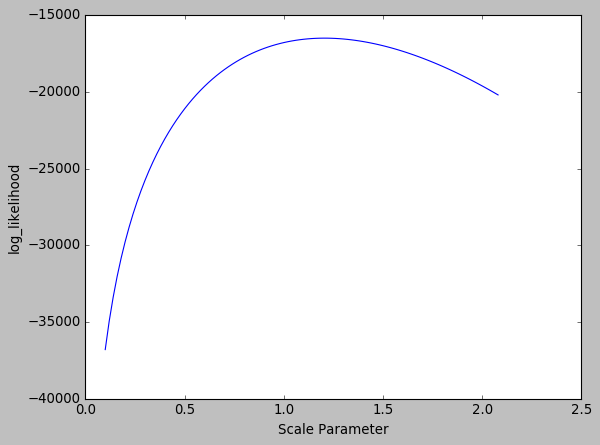

In [9]:
loglike = np.zeros(100)
xval = np.zeros(100)

for i in range(100):
    xval[i]=0.1+i*0.02
    loglike[i] = log_likelihood(data,0.1+i*0.02,2)

plt.plot(xval,loglike)
plt.ylabel('log_likelihood')
plt.xlabel('Scale Parameter')

1.0031561425
0.00555943607068
0.995157255998
0.995157255998


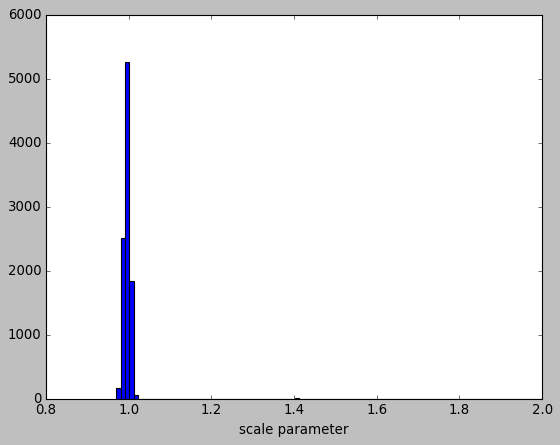

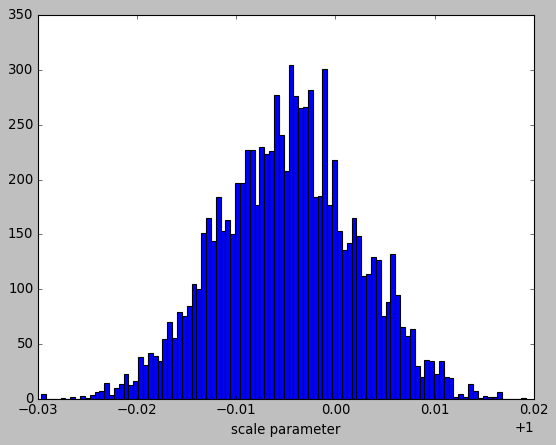

In [5]:
#A=A[1000:]# burn in 
B=A[1000:]
print(statistics.mean(A))
print(statistics.variance(A))
print(statistics.mean(B))
print(statistics.mean(B))
plt.hist(A,bins=100)# This looks pretty bad!
plt.xlabel("scale parameter")
plt.show()
plt.hist(B,bins=100)# this one looks better!
plt.xlabel("scale parameter")
plt.show()


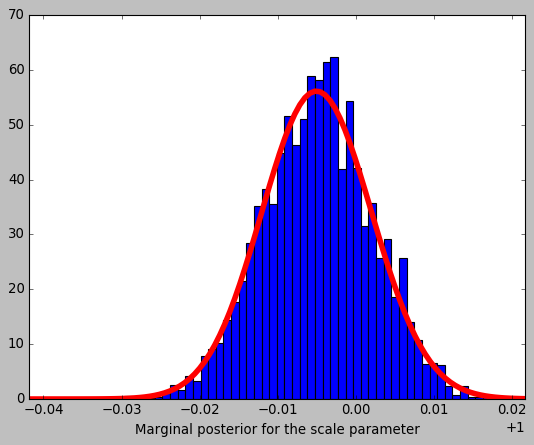

1.00511476025
5.05102585508e-05


In [6]:
a=ap+shape_fixed*n
b=bp/(1+bp*sum(data))
x = np.linspace(gamma.ppf(0.00000000001,a,scale=b),gamma.ppf(0.99, a,scale=b),100)
plt.plot(x,gamma.pdf(1/x,a,scale=b),'r-',lw=5,label='gamma pdf')
plt.hist(B,bins=50,normed=True)#range=[np.min(x),np.max(x)]
plt.xlabel("Marginal posterior for the scale parameter")
plt.xlim([np.min(x),np.max(x)])
plt.show()
print(gamma.mean(a,scale=b))
print(gamma.var(a,scale=b))


In [7]:
math.gamma(3)

2.0

In [8]:
def gamma_pdf(x,alpha,beta):
    return x**(alpha-1)*np.exp(-x/beta)/(math.gamma(alpha)*beta**alpha)

In [9]:
print(gamma_pdf(3,7,10))# they're the same mate
print(gamma.pdf(3,a=7,scale=10))

7.5007844844e-08
7.5007844844e-08


In [10]:
guess = 2# initial guess for scale
# Prepare storing MCMC chain as array of arrays.
def mh(guess):
    A = [guess]
# define stepsize of MCMC.
    stepsizes = 0.02 # array of stepsizes
    accepted  = 0.0
    old_theta=guess# define initial values for theta 
    old_loglik = log_likelihood(data,shape_fixed,old_theta)#calculate the first log likelihood
    old_logtarget=old_loglik+gamma.logpdf((1/old_theta),ap,scale=bp)
# Metropolis-Hastings with 500,000 iterations.
    for p in range(10000):
        new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
        #add the restraints on new_theta
        if new_theta<0: 
            continue
        new_loglik = log_likelihood(data,shape_fixed,new_theta)
        new_logtarget=new_loglik+gamma.logpdf((1/new_theta),ap,scale=bp)
# Accept new candidate in Monte-Carlo fashing.
        if (new_logtarget > old_logtarget):
            A.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
            old_logtarget=new_logtarget
        else:
            u = random.uniform(0.0,1.0)
            if (u < math.exp(new_logtarget-old_logtarget)):
                A.append(new_theta)
                accepted = accepted + 1.0  # monitor acceptance
                old_loglik=new_loglik
                old_theta=new_theta
                old_logtarget=new_logtarget 
            else:
                A.append(old_theta)
    print("Acceptance rate = "+str(accepted/10000.0))
    return A[1000:]#burn-in 1000

In [11]:
nchains=5 #the number of chains
sampless_scale = [mh(theta) for theta in np.linspace(0.5,7,nchains)]
# the starting points for the scale from 0.5 to 7                

Acceptance rate = 0.3893
Acceptance rate = 0.3929
Acceptance rate = 0.4001
Acceptance rate = 0.3979
Acceptance rate = 0.3961


In [12]:
len(sampless_scale[1])

9001

In [13]:
# x: data cell array
# m: no of chains run
# Within Chain Variance 
m=nchains
ssq_scale=np.zeros(m)
for j in range(0,m):
    ssq_scale[j]=np.var(sampless_scale[j])    
Wvar_scale=np.mean(ssq_scale)

In [14]:
# Between Chain Variance
schain_scale=0
chainlng_scale=len(sampless_scale[0])
for j in range(0,m):
    schain_scale = schain_scale + np.mean(sampless_scale[j])
mubar2_scale = (1/m)*schain_scale
bs_scale=0
for j in range(0,m):
    bs_scale=bs_scale+(np.mean(sampless_scale[j])-mubar2_scale)**2
Bvar_scale = (chainlng_scale/(m-1))*bs_scale
# Estimated variance
muvar_scale = (1-1/chainlng_scale)*Wvar_scale + (1/chainlng_scale)*Bvar_scale

# Potential Scale Reduction Factor
R_scale = np.sqrt(muvar_scale/Wvar_scale) 

print(R_scale)# smaller than 1.1, so the chain has converged.

0.999992466252


Text(0.5,0,'Number of iterations')

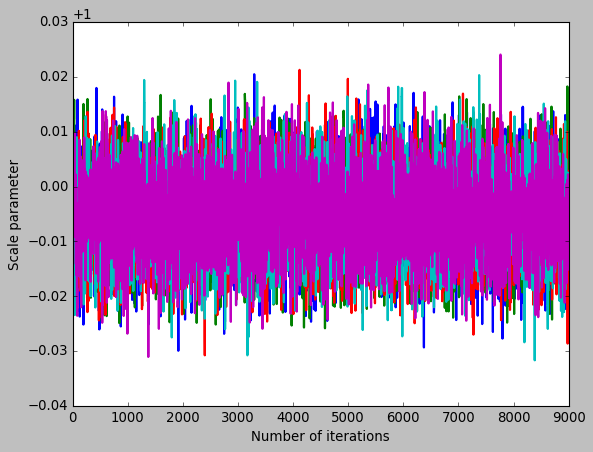

In [15]:
# Convergence of multiple chains for scale

for samples in sampless_scale:
    plt.plot(samples,lw=2)
#plt.xlim([0, 9001])#len of mh after burn-ib
#plt.ylim([0.5,7])
plt.ylabel("Scale parameter")
plt.xlabel("Number of iterations")